In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns
import os
import pickle
import numpy as np
from random import randint
from sklearn.metrics import roc_auc_score
from math import log10, log, log2
import plotly.express as px
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc

#For enlarging the display in cells:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))
#plt.rcParams['lines.markersize'] = 10 #increases the size of markers (default = 6)

from thesis_library import DATASETS, read_data, split_data_reader, read_score, try_auc, get_nice_timestamp_indices

C:\Users\user\AppData\Local\Temp\ipykernel_16404\4291712950.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# delete_procedures CSV:

In [ ]:
df = pd.read_csv('./CSV/rav_change_s.csv')
df.head(2)

In [ ]:
def plot_compact(target: str):
    '''
    target: whether to plot AUC or Time at the y axis
    TemporalDelete not present due to runtime issues to obtain it in the dataframe
    
    Is it MIDAS-R taxi not run? I do not think so, I think it is MIDAS-R CTU13 not run!'''
    
    assert target in ['Time', 'AUC'], "target needs to be 'Time' or 'AUC', got " + target
    
    df = pd.read_csv('./CSV/delete_procedures.csv')
    df = df[df['Dataset'] != 'ISCX'].reset_index(drop=True)
    df['Size'] = df['Size'].astype(str)
    df['Time'] = df['Time'].apply(lambda x: log2(x))
    
    df_no_delete_midas = df[(df['Method'] == 'NoDelete') & (df['Size'] == '32') & (df['MIDAS version'] == 'MIDAS')]
    df_no_delete_midas_r = df[(df['Method'] == 'NoDelete') & (df['Size'] == '32') & (df['MIDAS version'] == 'MIDAS-R')]
    df_random_delete = df[df['Method'] == 'RandomDelete']
    
    # Create two subplots and unpack the output array immediately
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4.5))

    ################## Plot 1 (NoDelete) #########################################
    sns.scatterplot(x='Size', y=target, data = df_random_delete[df_random_delete['MIDAS version'] == 'MIDAS'], \
                    hue = 'Dataset', ax=ax1)
    ax1.set_title("MIDAS")
    ax1.set_xlabel("Maximum size of the training graph \n (# unique edges)")
    ax1.legend(title='Dataset', bbox_to_anchor=(1, 1));
    
    #Adding horizontal lines for NoDelete:   #ax.axhspan(0.3, 0.7, alpha=0.2)
    for dataset_index in range(0, 5):
        ax1.axhline(df_no_delete_midas['AUC'].iloc[dataset_index], color=sns.color_palette()[dataset_index])
    
    if target == 'Time':
        ax1.set_ylabel('log_2(Time) (in seconds)')
    else:
        ax1.set_ylabel('ROC-AUC')
    
    ################## Plot 2 (RandomDelete) #####################################
    sns.scatterplot(x='Size', y=target, data=df_random_delete[df_random_delete['MIDAS version'] == 'MIDAS-R'], \
                    hue = 'Dataset', legend=False, ax=ax2)
    ax2.set_title("MIDAS-R")
    ax2.set_xlabel("Maximum size of the training graph \n (# unique edges)")
    
    #Adding horizontal lines for NoDelete:
    for dataset_index in range(0, 5):
        ax2.axhline(df_no_delete_midas_r['AUC'].iloc[dataset_index], color=sns.color_palette()[dataset_index])

    plt.tight_layout(w_pad=0.3)
    
    if 'Delete_types_' + target + '.pdf' not in os.listdir('./Figures - PDF'):
        plt.savefig('./Figures - PDF/' + 'Delete_types_' + target + '.pdf')
    plt.show();

In [ ]:
plot_compact(target='Time')

# test_on_splits CSV & dataset_info CSV (split data reader):

In [ ]:
df, df_statistics = split_data_reader('NYC_Taxi')
df[df['MIDAS']=='No sketch']#.head(2)

In [78]:
def plot_auc_and_split_per_dataset(dataset: str | None, figsize=(18, 10)):
    '''
    We produce multiple plots here:
    1) No Sketch + LPs per split
    2) MIDAS     + LPs per split
    3) MIDAS-R   + LPs per split
    4) Custom    + LPs per split
    5) Custom vs. Custom + PA vs. MIDAS vs. MIDAS + PA vs. MIDAS-R vs. MIDAS-R + PA
    6) Anomaly percentages
    '''
    
    #Preparing the canvas, color palette and reading the datasets:
    plt.figure(figsize=figsize)
    warp = sns.color_palette()[1:4] + [sns.color_palette()[0]] #Making the usual color palette go 1-2-3-0th colors
    df, df_stats = split_data_reader(dataset)
    
    #Making one dataset for MIDAS, one for MIDAS-R, one for Custom and one for no sketch:
    df_no_sketch = df[df['MIDAS']=='No sketch'].reset_index(drop=True)
    df_regular = df[df['MIDAS']=='MIDAS'].reset_index(drop=True)
    df_relational = df[df['MIDAS']=='MIDAS-R'].reset_index(drop=True)
    df_custom = df[df['MIDAS']=='Custom'].reset_index(drop=True)

    #Finding the baseline scores for MIDAS, MIDAS-R and Custom:
    baseline_no_sketch = 0.5 #random guessing
    baseline_midas = df_regular[df_regular['Split (train:test)'] == '00:10']['AUC'].iloc[0]
    baseline_midas_r = df_relational[df_relational['Split (train:test)'] == '00:10']['AUC'].iloc[0]
    baseline_custom = df_custom[df_custom['Split (train:test)'] == '00:10']['AUC'].iloc[0]
    
    #The positions (i, j, k) work like that:
    #Imagine there is a grid with i rows, j columns. Root your plot in k-th index (reading order)
    
    ############## Plot 1 - NoSketch + LPs per split ###########################################
    df_no_sketch.loc[-1] = ['00:10', dataset, -1, -1, 'No sketch', 'Guessing value', 0.5, -1]
    
    ax1 = plt.subplot(6, 1, 1)
    ax1.axhline(y=baseline_no_sketch, ls='--')
    sns.pointplot(x = 'Split (train:test)', y = 'AUC', hue = 'Method', data=df_no_sketch, palette=warp, ax=ax1)
    plt.title('ROC/AUC per train-test split on pure LPs. Dataset = '+dataset, fontsize=14)
    
    ############## Plot 2 - MIDAS + LPs per split ##############################################
    ax2 = plt.subplot(6, 1, 2)
    ax2.axhline(y=baseline_midas, ls='--')
    sns.pointplot(x = 'Split (train:test)', y = 'AUC', hue = 'Method', data=df_regular, palette=warp, ax=ax2)
    plt.title('ROC/AUC per train-test split on MIDAS baseline. Dataset = '+dataset, fontsize=14)
    
    ############## Plot 3 - MIDAS-R + LPs per split ############################################
    ax3 = plt.subplot(6, 1, 3)
    ax3.axhline(y=baseline_midas_r, ls='--')
    sns.pointplot(x = 'Split (train:test)', y = 'AUC', hue = 'Method', data=df_relational, palette=warp, ax=ax3)
    plt.title('ROC/AUC per train-test split on MIDAS-R baseline. Dataset = '+dataset, fontsize=14)
    
    ############## Plot 4 - Custom + LPs per split #############################################
    ax4 = plt.subplot(6, 1, 4)
    ax4.axhline(y=baseline_custom, ls='--')
    sns.pointplot(x = 'Split (train:test)', y = 'AUC', hue = 'Method', data=df_custom, palette=warp, ax=ax4)
    plt.title('ROC/AUC per train-test split on Custom baseline. Dataset = '+dataset, fontsize=14)
    
    ############## Plot 5 - Custom vs. Custom + PA vs. MIDAS + PA vs. MIDAS-R + PA ###########
    ax5 = plt.subplot(6, 1, 5)
    
    #Preparing the display by merging the MIDAS and Method columns:
    df = df[df['MIDAS'] != 'No sketch']
    df = df[(df['Method'] == 'No LP') | (df['Method'] == 'Preferential Attachment')]
    df['Method'] = df['MIDAS'] + '+' + df['Method']
    
    sns.pointplot(x = 'Split (train:test)', y = 'AUC', hue = 'Method', data=df, palette=sns.color_palette()[4:], ax=ax5)
    plt.title('Crucial methods comparison. Dataset = '+dataset, fontsize=14)
    
    ############## Plot 6  - Train/test set anomaly edges percenteges ############################
    ax6 = plt.subplot(6, 1, 6)
    sns.pointplot(x = 'Split (train:test)', y = 'Train_anomaly_percentage', data = df_stats, color='#37e54c', ax=ax6)
    sns.pointplot(x = 'Split (train:test)', y = 'Test_anomaly_percentage', data = df_stats, color='#215bae', ax=ax6)
    
    ax6.set_ylabel('Anomaly share')
    ax6.legend(['Train set', 'Test set'], loc='center right');
    leg = ax6.get_legend()
    leg.legend_handles[0].set_color('#37e54c')
    leg.legend_handles[1].set_color('#215bae')
    
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.get_xaxis().set_visible(False)
        ax.legend(loc='lower right')
        #ax.set_xlabel('') #This if you want to hide the title, but let the ticks remain
    
    if dataset+'.pdf' not in os.listdir('./Figures - PDF/AUC_on_splits/'):
        plt.savefig("./Figures - PDF/AUC_on_splits/" + dataset + '.pdf', bbox_inches='tight')
    plt.show();

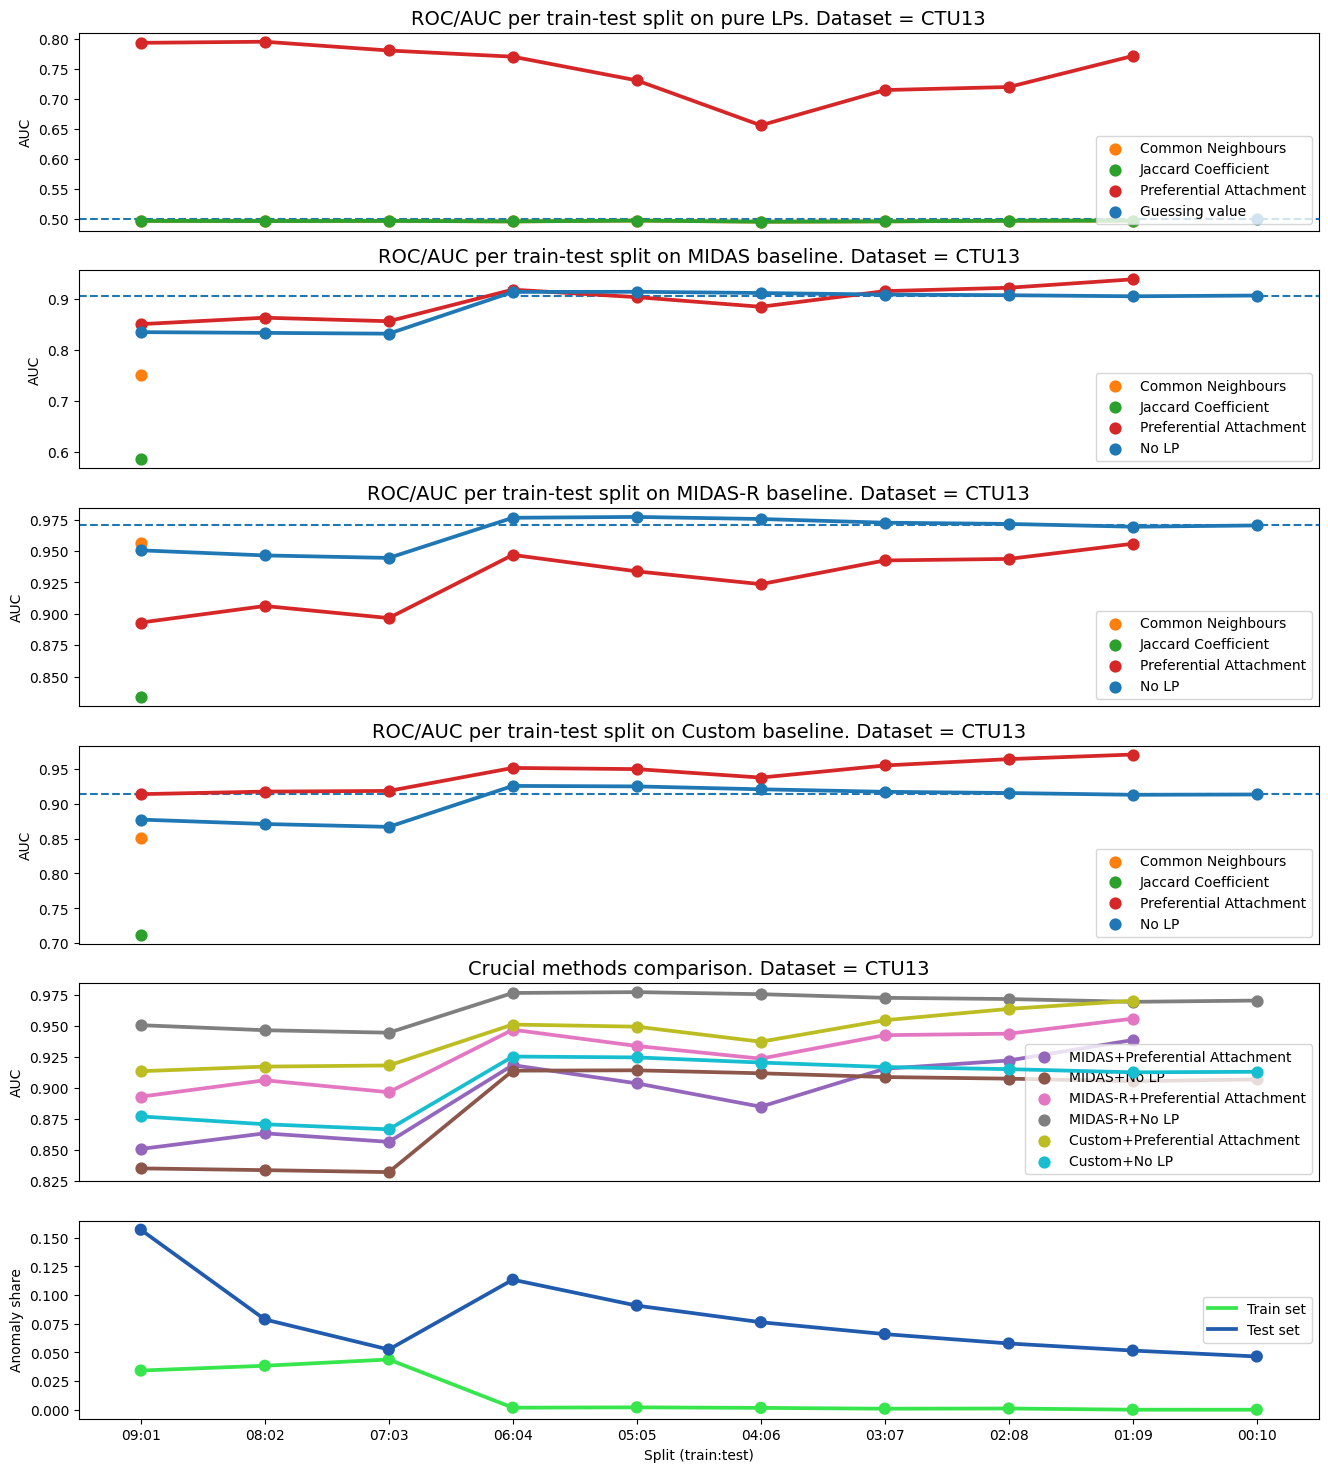

In [79]:
# for dataset in DATASETS:
#     plot_auc_and_split_per_dataset(dataset, figsize=(16, 18))

plot_auc_and_split_per_dataset('CTU13', figsize=(16, 18))

In [ ]:
def plot_anomaly_edges_percentage(dataset: str | None, figsize=(12, 9), show_train=True, show_test=True, ylim=False):
    '''Plots the anomaly percentage per split size for ALL datasets'''
    
    _, df = split_data_reader(dataset)
    df = df[df['Dataset'] != 'ISCX'].reset_index(drop=True)
    filename = "percentage_anomaly_full.pdf"
    
    plt.figure(figsize=figsize, dpi=80)
    ax1 = plt.subplot(1, 2, 1) #nrows, ncols, index
    ax2 = plt.subplot(1, 2, 2) #nrows, ncols, index
    
    sns.pointplot(x = 'Split (train:test)', y = 'Train_anomaly_percentage', hue = 'Dataset', data = df, ax=ax1)
    ax1.set_title('Percentage of anomaly edges in training dataset')
    ax1.set_ylabel('')
    
    sns.pointplot(x = 'Split (train:test)', y = 'Test_anomaly_percentage', hue = 'Dataset', data = df, ax=ax2)
    ax2.get_legend().set_visible(False)
    ax2.set_title('Percentage of anomaly edges in testing dataset')
    ax2.set_ylabel('')
    
    if type(ylim) is float:
        filename = "percentage_anomaly_full_zoomed.pdf"
        ax1.set_ylim(0, ylim)
        ax2.set_ylim(0, ylim)
    
    if filename not in os.listdir("./Figures - PDF") and dataset is None:
        plt.savefig("./Figures - PDF/"+filename, bbox_inches='tight')
    
    plt.show();

In [ ]:
plot_anomaly_edges_percentage(dataset=None, figsize=(14,4))#, ylim=0.15)

In [4]:
def plot_auc_comparison(dataset: str, midas_version = 'MIDAS'):
    '''Compares the pure MIDASes with their LP reinforcement versions'''
    
    assert dataset in DATASETS, "Wrong dataset passed, got " + dataset
    assert midas_version in ["MIDAS", "MIDAS-R"], "Wrong midas version passed, got " + midas_version
    
    if dataset == "CTU13": #broken dataset
        return 0
    
    df, _ = split_data_reader(dataset)
    
    #Leaving only the rows we will be plotting
    df = df[df['MIDAS'] == midas_version]
    
    #Getting the data for the MIDAS and MIDAS-R reference values
    row_midas = df[df['Split (train:test)'] == '00:10']['AUC']
    score_midas, index_midas = row_midas.iloc[0], row_midas.index[0]
    
    #To avoid double plotting MIDAS and MIDAS-R reference values:
    df = df.drop([index_midas]).reset_index(drop=True)
    
    #Making the scatterplot
    plt.figure(figsize=(6, 3), dpi=100)
    sns.scatterplot(x = 'Method', y = 'AUC', data = df, hue = 'Split (train:test)', palette='viridis') #crest
    plt.xticks(rotation=20)
    
    #Adding a horizontal line for the given dataset with reference value:
    plt.axhline(score_midas, ls='--')
    if dataset == 'NB15' and midas_version == 'MIDAS':
        plt.text(0.2, score_midas-0.015, midas_version+" baseline (00:10)", size=10, alpha=0.9, weight='light')
    else:
        plt.text(0.2, score_midas+0.004, midas_version+" baseline (00:10)", size=10, alpha=0.9, weight='light')
    
    #Dealing with the rest of plotting stuff:
    plt.xlabel('')
    plt.title('AUC/ROC with ' + midas_version + ' baseline on dataset ' + dataset)
    plt.legend('',frameon=False)
    plt.legend(title='Split (train:test)', bbox_to_anchor=(1,1), ncols=2)
    if midas_version + ' ' + dataset + '.pdf' not in os.listdir('./Figures - PDF/AUC baseline comparison'):
        plt.savefig('./Figures - PDF/AUC baseline comparison/'+midas_version+' '+ dataset+'.pdf', bbox_inches='tight')
    plt.show()

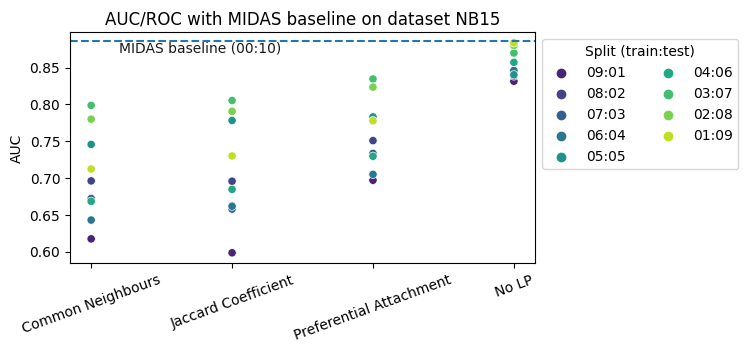

In [5]:
# for dataset in DATASETS:
#     plot_auc_comparison(dataset, 'MIDAS')
#     plot_auc_comparison(dataset, 'MIDAS-R')
    
plot_auc_comparison('NB15', 'MIDAS')

In [ ]:
def plot_time_vs_split(dataset: str, midas_version: str):
    ''''''
    
    df, _ = split_data_reader(dataset)
    df = df[df['MIDAS'] == midas_version]
    df = df[(df['Method'] != 'none') & (df['Split (train:test)'] != '00:10')].reset_index(drop=True)
    df['Time [s]'] = df['Time [s]'].apply(lambda x: log2(x) if x != -1 else -1)
    
    plt.figure(figsize=(8,2), dpi=100)

    palette = sns.color_palette(["#4c72b0","#4c72b0","#55a868","#55a868","#c44e52","#c44e52"])
    sns.pointplot(x = 'Split (train:test)', y = 'Time [s]', data = df, 
                  hue='Method', palette=sns.color_palette()[1:]) #skip the 1st colour
    
#     sns.pointplot(x = 'Split (train:test)', y = 'Time_per_k_edges', data = df[df['Dataset']==dataset], 
#                   hue='Method', palette=sns.color_palette("pastel")[1:]) #skip the 1st colour
    
    #plt.legend(title='', bbox_to_anchor=(1,1))
    plt.legend('', frameon=False)
    plt.ylabel("log_2(Time) (seconds)")
    plt.title('Time needed to LP-process (per split) dataset ' + dataset + ' on ' + midas_version + ' baseline')
    
    filename = midas_version + ' ' + dataset + '.pdf'
    if filename not in os.listdir('./Figures - PDF/Time_vs_split'):
        plt.savefig('./Figures - PDF/Time_vs_split/' + filename, bbox_inches='tight')
        
    plt.show();

In [ ]:
# for dataset in DATASETS:
#     plot_time_vs_split(dataset, 'MIDAS')
#     plot_time_vs_split(dataset, 'MIDAS-R')

plot_time_vs_split('CTU13', 'MIDAS-R')

In [ ]:
def plot_runtime_comparison_full():
    '''CTU13 deleted due to immense runtime and size skewing the results'''
    
    df, _ = split_data_reader(None)
    df = df[df['Dataset'] != 'ISCX'].reset_index(drop=True)
    df = df[(df['#nodes'] != -1) & (df['Time [s]'] > 0)]
    #df['Time [s]'] = df['Time [s]'].apply(lambda x: log10(x))
    #df = df[df['Dataset'] != 'CTU13']
    
    plt.figure(figsize=(7,5), dpi=100)
    plt.xscale('log')
    plt.yscale('log')
    sns.scatterplot(x='#nodes', y='#edges', data=df, hue='Split (train:test)', palette='viridis', 
                    style='Dataset', size='Time [s]')
    plt.legend(bbox_to_anchor=(1,1), markerscale=1, ncols=2)
    plt.title('Runtime comparison per dataset, its split and size')
    plt.xlabel('Number of nodes in training split')
    plt.ylabel('Number of edges in training split')
    if 'runtime_comparison_full.pdf' not in os.listdir('./Figures - PDF'):
        plt.savefig('./Figures - PDF/runtime_comparison_full.pdf', bbox_inches='tight')
    
    plt.show();
    
plot_runtime_comparison_full()

# bizarre_sketches CSV

In [ ]:
df = pd.read_csv('./CSV/bizarre_sketches.csv')
df.head(2)

In [ ]:
def plot_bizarre_sketches():
    ''''''
    
    df = pd.read_csv('./CSV/bizarre_sketches.csv')
    df = df[df['Dataset'] != 'ISCX'].reset_index(drop=True)
    df = df[df['Method'] != 'RDS'].reset_index(drop=True) #not enough rows to make sense
    plt.figure(figsize=(8,4), dpi=100)
    
    df = df[df['p'] == 2] #erasing useless p values
    #df['Divide'] = df['Divide'].astype(str) #doesn't do anything, it seems
    
    sns.scatterplot(x = 'Dataset', y = 'AUC/ROC', data = df, hue = 'Method', style='Divide', s=100, alpha=0.9)
    plt.title("AUC score per dataset per sample type used")
    if 'auc_bizarre_sketches.pdf' not in os.listdir('./Figures - PDF'):
        plt.savefig("./Figures/auc_bizarre_sketches.pdf", bbox_inches='tight')
    
    plt.legend(bbox_to_anchor=(1,1));
    plt.show();

In [ ]:
plot_bizarre_sketches()

In [ ]:
def plot_p():
    '''Per dataset and per p-value plot of AUC. Can get NYC Taxi added if we feel like it'''
    
    df = pd.read_csv('./CSV/bizarre_sketches.csv')
    df = df[df['Dataset'] != 'ISCX'].reset_index(drop=True)
    
    plt.figure(figsize=(8,4), dpi=100)
    ax = plt.subplot(1, 1, 1)
    
    df = df[df['Method'] == 'Sampler']
    
    sns.pointplot(x = 'p', y = 'AUC/ROC', hue = 'Dataset', data = df, ax=ax)
        
    plt.title("Sample sketch's AUC score by parameter p")
    if 'Sample_AUC_by_p_rav.pdf' not in os.listdir('./Figures'):
        plt.savefig("./Figures/Sample_AUC_by_p_rav.pdf", bbox_inches='tight')
    plt.legend(bbox_to_anchor=(1,1));
    plt.show();

In [ ]:
plot_p()

In [18]:
def plot_auc(dataset: str):
    ''''''
    
    X, y = read_data(dataset)

    filename = 'perfect_' + dataset + '.txt'
    with open('./data/scores/' + filename, 'rb') as fp:
        score_perfect = pickle.load(fp)

    score_custom = read_score('Custom', dataset)
    score_midas = read_score('MIDAS', dataset)
    
    plt.figure()

    fpr, tpr, thresholds = roc_curve(y, score_perfect) 
    plt.plot(fpr, tpr, label='Perfect (area = %0.4f)' % auc(fpr, tpr))

    fpr, tpr, thresholds = roc_curve(y, score_midas) 
    plt.plot(fpr, tpr, label='MIDAS (area = %0.4f)' % auc(fpr, tpr))

    fpr, tpr, thresholds = roc_curve(y, score_custom) 
    plt.plot(fpr, tpr, label='Custom (area = %0.4f)' % auc(fpr, tpr))

    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for dataset ' + dataset)
    plt.legend()
    if 'roc_' + dataset + '.pdf' not in os.listdir('./Figures - PDF'):
        plt.savefig('./Figures - PDF/roc_' + dataset + '.pdf')
    plt.show()

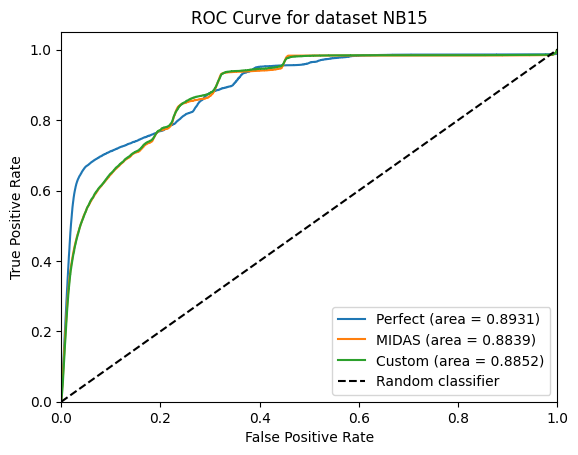

In [19]:
plot_auc('NB15')

# custom_sketch_test.csv

In [ ]:
df = pd.read_csv('./CSV/custom_sketch_test.csv')
df

In [ ]:
# df = pd.read_csv('./CSV/rav_sketch_first_test.csv')
# df = df[df['Dataset'] != 'ISCX']
# df = df[(df['Depth'] == 3) & (df['Length'] == 16) & (df['K'] == 6)].sort_values('LP scale')
# #df['LP scale'] = df['LP scale'].astype(str)
# df = df[['Dataset', 'AUC', 'LP scale']].reset_index(drop=True)
# df = df.set_index('LP scale')
# df['DARPA'] = df[df['Dataset'] == 'DARPA']['AUC']
# df['NB15'] = df[df['Dataset'] == 'NB15']['AUC']
# df['CTU13'] = df[df['Dataset'] == 'CTU13']['AUC']
# df['Gowalla'] = df[df['Dataset'] == 'Gowalla']['AUC']
# df['NYC_Taxi'] = df[df['Dataset'] == 'NYC_Taxi']['AUC']
# df = df.drop(['Dataset', 'AUC'], axis=1)
# df = df.drop_duplicates()
# df = df.reset_index(drop=False)
# df

In [ ]:
def plot_lp_scale(dataset: str):
    ''''''
    
    df = pd.read_csv('./CSV/custom_sketch_test.csv')
    df = df[(df['Dataset'] == dataset)]
    df = df[(df['Depth'] == 3) & (df['Length'] == 16) & (df['K'] == 6)].sort_values('LP scale')
    df['LP scale'] = df['LP scale'].astype(str)
    #df['Time [s]'] = df['Time [s]'].apply(lambda x: log10(x))
    
    plt.figure(figsize=(6, 4.5), dpi=100)
#     if dataset == 'NYC_Taxi':
#         plt.ylim(df['AUC'].min() - 0.0001, df['AUC'].max() + 0.0001)
    
    sns.scatterplot(x='Runtime', y='AUC', data=df, hue='LP scale', palette='viridis', legend = False) 
    #plt.legend(title='LP scale', bbox_to_anchor=(1, 1), markerscale=1.1, ncols = 2)
    plt.title('Custom sketch (3, 16, 6) - LP scale impact on dataset = '+dataset)
    plt.xlabel('Runtime [s]')
    plt.ylabel('AUC')
    if dataset+'.pdf' not in os.listdir('./Figures - PDF/LP scale impact'):
        plt.savefig('./Figures - PDF/LP scale impact/' +dataset+ '.pdf', bbox_inches='tight')
    
    plt.show();

In [ ]:
# for dataset in DATASETS:
#     plot_lp_scale(dataset)
    
plot_lp_scale('NYC_Taxi')

In [ ]:
def plot_lp_scale_pcp():
    ''''''
    
    df = pd.read_csv('./CSV/custom_sketch_test.csv')
    df = df[df['Dataset'] != 'ISCX']
    df = df[(df['Depth'] == 3) & (df['Length'] == 16) & (df['K'] == 6)].sort_values('LP scale')
    #df['LP scale'] = df['LP scale'].astype(str)
    df = df[['Dataset', 'AUC', 'LP scale']].reset_index(drop=True)
    df = df.set_index('LP scale')
    df['DARPA'] = df[df['Dataset'] == 'DARPA']['AUC']
    df['NB15'] = df[df['Dataset'] == 'NB15']['AUC']
    df['CTU13'] = df[df['Dataset'] == 'CTU13']['AUC']
    df['Gowalla'] = df[df['Dataset'] == 'Gowalla']['AUC']
    df['NYC_Taxi'] = df[df['Dataset'] == 'NYC_Taxi']['AUC']
    df = df.drop(['Dataset', 'AUC'], axis=1)
    df = df.drop_duplicates()
    df = df.reset_index(drop=False)
    
    fig = px.parallel_coordinates(df, color="LP scale", dimensions=DATASETS, title='AUC per various LP scale values')
    fig.show()

In [ ]:
plot_lp_scale_pcp()

In [ ]:
def plot_k(dataset: str):
    ''''''
    
    df = pd.read_csv('./CSV/custom_sketch_test.csv')
    df = df[(df['LP scale'] == 1) & (df['Dataset'] == dataset) & (df['Depth'] != 7)]
    df_4_5 = df[(df['Depth'] == 4) & (df['Length'] == 5)].reset_index(drop=True)
    df_3_16 = df[(df['Depth'] == 3) & (df['Length'] == 16)].reset_index(drop=True)

    plt.figure(figsize=(5.5, 4), dpi=100)
    #plt.xscale('log')
    #plt.yscale('log')
    ax = sns.scatterplot(x='Runtime', y='AUC', data=df, hue='K', palette='viridis', style='Depth')#, size='Time [s]')
    
    handles, labels = ax.get_legend_handles_labels()
    labels = ['K', '3', '4', '5', '6', '7', '8', 'Shape', '(3, 16, k)', '(4, 5, k)']
    ax.legend(handles, labels, bbox_to_anchor=(1,1), markerscale=1)
    
    plt.title('Impact of $k$ on AUC and runtime. Dataset = '+dataset)
    plt.xlabel('Runtime [s]')
    plt.ylabel('ROC-AUC')
    if dataset+'.pdf' not in os.listdir('./Figures - PDF/k impact'):
        plt.savefig('./Figures - PDF/k impact/' + dataset + '.pdf', bbox_inches='tight')
    
    plt.show();

In [ ]:
for dataset in DATASETS:
    plot_k(dataset)
    
#plot_k('DARPA')

# Not CSVs, but saved scores

In [ ]:
score = read_score('Custom', 'ISCX')

In [ ]:
X, y = read_data('NB15')

# with open('./data/scores/midas_testing_a_NB15.txt', 'rb') as fp:
#     score_midas_a_NB15 = pickle.load(fp)
    
# with open('./data/scores/midas_testing_st_NB15.txt', 'rb') as fp:
#     score_midas_st_NB15 = pickle.load(fp)
    
# with open('./data/scores/score_pa_0.5_DARPA.txt', 'rb') as fp:
#     score_pa = pickle.load(fp)

In [ ]:
def plot_score_info(alg_name: str, dataset: str, depth=None, length=None, k=None, sample=True):
    '''Plots the cumulative score distribution and the entire score distribution
    You might want to pass depth, length, k - but you do not have to
    Use sample=True for only plotting 2000 scores (random timewise split)
    
    TO DO: add the mean and median to the plots'''
    
    sns.set_style('whitegrid')
    plt.tight_layout()
    plt.figure(figsize=(10, 6), dpi=100)
    
    #Reading and structuring data:
    score = read_score(alg_name, dataset)
    X, y = read_data(dataset, plant='clique')
    
    if sample:
        start = randint(0, len(X)-2001)
        X, y, score = X[start : start+2000], y[start : start+2000], score[start : start+2000]
    
    df = pd.DataFrame({"score": score, 'x': list(range(len(score))), 'y': y[:len(score)]})
    df_regular = df[df['y'] == 0]
    df_anomaly = df[df['y'] == 1]
    
    #Standardizing the title:
    if depth is not None and length is not None:
        title = alg_name + "(" + str(depth) + ", " + str(length) + ")"
        if k is not None:
            title = title[:-1] + ", " + str(k) + ")"
    title += ". Dataset = " + dataset
    
    #print("Median score regular:", df_regular['score'].median())
    #print("Median score anomaly:", df_regular['score'].median())
    
    #Plotting all the scores:
    ax1 = plt.subplot(2, 1, 1)
    sns.lineplot(data=df_regular, x='x', y='score', ax=ax1, color='#123D66') #blue
    sns.lineplot(data=df_anomaly, x='x', y='score', ax=ax1, color='#A21B37') #red
    ax1.set_title("Score values over time. " + title)
    ax1.set_xlabel("Edge number")
    ax1.set_ylabel("Score")
    
    #Plotting the score distribution:
    ax2 = plt.subplot(2, 1, 2)
    sns.kdeplot(np.array(score), color='#123D66', ax=ax2)
    sns.kdeplot(np.array(df_anomaly['score']), color='#A21B37', ax=ax2)
    ax2.set_title('Score distribution in ' + title)
    ax2.set_xlabel('Given scores')
    ax2.set_ylabel('Density')
    
    #Saving the plot if needed:
    if alg_name + " " + dataset+'.pdf' not in os.listdir('./Figures - PDF/Score distribution/Plot type 1'):
        plt.savefig('./Figures - PDF/Score distribution/Plot type 1/'+alg_name + " " + dataset+'.pdf')
    plt.show();

In [ ]:
for dataset in DATASETS:
    plot_score_info("MIDAS", dataset, 3, 32, 5, sample=False)

In [ ]:
def plot_score_info_2(dataset: str, alg_name: str, start=None, end=None, 
                      full_timestamp=False, number_of_edges=100):
    '''The zoomed-in version with 2 bars per edge
    Put the indices of X into start, end; or set them to None to select some randomly
    
    TO DO: test after changes made'''
    
    fig = plt.figure(figsize = (12, 5), dpi=100);
    #plt.tight_layout()
    ax = fig.add_subplot(111)
    
    #Reading and structuring data:
    score = read_score(alg_name, dataset)
    X, y = read_data(dataset, plant='clique')
    
    if start is None or end is None:
        start, end = get_nice_timestamp_indices(X, y, full_timestamp, number_of_edges)
        #print("Indices of the slice:", start, end)

    df = pd.DataFrame({'True': y[start : end],
                      'Predicted': score[start : end]})
    
    #### ADDING THE STATISTIC BOX
    info_text = "Median score of non-anomaly edges: " + str(round(df[df['True']==0]['Predicted'].median(), 3)) + '\n' + \
    "Median score of anomaly edges:        " + str(round(df[df['True']==1]['Predicted'].median(), 3)) + '\n' + \
    "AUC on the slice:                                 " + str(round(roc_auc_score(df['True'], df['Predicted']), 4))
    #"AUC on the slice:                                " + str(round(try_auc(df['True'], df['Predicted']), 4))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    #### THE ACTUAL PLOTTING
    max_value = df['Predicted'].max()
    df['Predicted'] = df['Predicted'].apply(lambda x: x/max_value)
    df['True'] = df['True'].apply(lambda x: x+0.006)

    df.plot(kind='bar', ax=ax);

    #Display purposes:
    plt.xticks(ticks = range(end - start), labels = X[start : end])
    plt.legend(loc='upper right')
    
    if end - start > 60:
        for label in ax.xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
       
    plt.title("Edges scoring in dataset "+dataset+" by sketch: "+alg_name+". Slice: "+str(start)+"-"+str(end));
    
    filename = alg_name + " " + dataset + " " + str(start) + "-" + str(end) + ".pdf"
    if filename not in os.listdir('./Figures - PDF/Score distribution/Plot type 2'):
        plt.savefig('./Figures - PDF/Score distribution/Plot type 2/' + filename, bbox_inches="tight")#pad_inches=0.6)

In [ ]:
plot_score_info_2("NYC_Taxi", "MIDAS", full_timestamp=False, number_of_edges=90)
%matplotlib inline

In [ ]:
def plot_score_info_3(score_a: list, score_st: list, y_true: list, dataset: str, method: str, start=None, end=None, 
                      full_timestamp=False, number_of_edges=100):
    '''Just like the above but plotting _st and _a separately. Only for MIDAS'''
    
    fig = plt.figure(figsize = (12, 6), dpi=100);
    ax = fig.add_subplot(111)
    
    if start is None or end is None:
        start, end = get_nice_timestamp_indices(X, y, full_timestamp, number_of_edges)

    df = pd.DataFrame({'True': y_true[start : end],
                      'Predicted_a': score_a[start : end],
                      'Predicted_st': score_st[start : end]})
    
    #### ADDING THE STATISTIC BOX
    #Taking the AUC stats from the combined scores:
    df['Predicted'] = df['Predicted_a'] + df['Predicted_st']
    
    #Creating the text for the AUC info box:
    info_text = "Median score of non-anomaly edges: " + str(round(df[df['True']==0]['Predicted'].median(), 3)) + '\n' + \
    "Median score of anomaly edges:        " + str(round(df[df['True']==1]['Predicted'].median(), 3)) + '\n' + \
    "AUC on the slice:                                " + str(round(try_auc(df['True'], df['Predicted']), 4))
    
    #Deleting the combined score to avoid having a separate bar for it:
    df = df.drop(['Predicted'], axis=1)

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    #### THE ACTUAL PLOTTING
    max_value_a, max_value_st = df['Predicted_a'].max(), df['Predicted_st'].max()
    df['Predicted_a'] = df['Predicted_a'].apply(lambda x: x/(max_value_a*2))
    df['Predicted_st'] = df['Predicted_st'].apply(lambda x: x/(max_value_st*2))
    df['True'] = df['True'].apply(lambda x: x+0.006)
    
    df['True'].plot(kind='bar', figsize=(12, 6), ax=ax, stacked=False, color='blue')
    df[['Predicted_st', 'Predicted_a']].plot(kind='bar', stacked=True, color=['orange', 'green'], position=0, ax=ax);

    #Display purposes:
    plt.xticks(ticks = range(end - start), labels = X[start : end])
    plt.legend(loc='upper right')
    
    if end - start > 60:
        for label in ax.xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
       
    plt.title("Edges scoring in dataset " + dataset + " by sketch: " + method + ". Starting index: " + str(start));

In [ ]:
plot_score_info_3(score_midas_a_NB15, score_midas_st_NB15, y, "NB15", "MIDAS", full_timestamp=False)
#3111

In [ ]:
# #Exerpt from pyMIDAS:
# row = 4
# col = 128
# param = [randint(1, 2**16) for _ in range(2*row)]#.astype(i4)
# print(param)

# for src, dst in [(33, 18), (21, 31), (14, 26), (19, 38), (14, 26), (33, 27), (16, 22), (15, 3)]:
#     for i in range(1):
#         i = (1 * col + ((src + 347 * dst) * param[1] + param[1 + row]) % col ) %row
#         print(src, dst, i)

# advice_test CSV

In [ ]:
df = pd.read_csv('./CSV/advice_test.csv')
df.head(2)

In [ ]:
def plot_advice_pcp():
    ''''''
    
    df = pd.read_csv('./CSV/advice_test.csv')
    df = df[(df['Dataset'] != 'ISCX') & (df['AUC_sketch'] != -1) & (df['AUC_advice'] != -1)].reset_index(drop=True)
    df['Dataset'] = df['Dataset'].replace({'DARPA': 1, 'NB15': 2, 'CTU13': 3, 'Gowalla': 4, 'NYC_Taxi': 5})
    #df['Dataset'] = df['Dataset'].replace({'DARPA': '#453645', 'NB15': '#423465', 'CTU13': '#AB4986', 'Gowalla': '#DEF647', 'NYC_Taxi': '#999999'})
    
    minimal_value = min(df['AUC_sketch'].min(), df['AUC_advice'].min())
    row = ['09:01', 2, 4, 5, 6, -1, -1, -1, -1, -1, -1, -1, -1, 'wow', minimal_value, minimal_value]
    df.loc[df.shape[0]] = row
    
    maximal_value = max(df['AUC_sketch'].max(), df['AUC_advice'].max())
    row = ['09:01', 2, 4, 5, 6, -1, -1, -1, -1, -1, -1, -1, -1, 'wow', maximal_value, maximal_value]
    df.loc[df.shape[0]] = row
    
    fig = px.parallel_coordinates(df, color="Dataset",
                                  dimensions=['AUC_sketch', 'AUC_advice'],
                                  color_continuous_scale= [[0.00, '#7a3ef3'],
                                                           [0.20, '#7a3ef3'],
                                                           [0.21, '#61b9ec'],
                                                           [0.40, '#61b9ec'],
                                                           [0.41, '#51e0a8'],
                                                           [0.60, '#51e0a8'],
                                                           [0.61, '#52c855'],
                                                           [0.80, '#52c855'],
                                                           [0.81, '#e8f33e'],
                                                           [1.00, '#e8f33e']])
    fig.show()

In [ ]:
plot_advice_pcp()

In [ ]:
def plot_advice_histogram():
    ''''''
    
    #df formatting:
    df = pd.read_csv('./CSV/advice_test.csv')
    df = df[(df['Dataset'] != 'ISCX') & (df['AUC_sketch'] != -1) & (df['AUC_advice'] != -1)].reset_index(drop=True)
    df['Change [%]'] = round((df['AUC_advice'] - df['AUC_sketch']) / df['AUC_sketch'] * 100, 2)
    number_decreased = df[df['Change [%]'] < 0].shape[0]
    number_unchanged = df[df['Change [%]'] == 0].shape[0]
    
    #Plot creation:
    ax = df['Change [%]'].plot(kind='hist', bins=30, color='#881ABB', figsize=(8, 5))
    
    # place a text box in upper left in axes coords
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    text = '# test cases that decreased score:   ' + str(number_decreased) + \
    ' \n# test cases with unchanged score:  ' + str(number_unchanged) + \
    ' \n# test cases that improved score:     ' + str(df.shape[0] - number_decreased - number_unchanged)
    
    ax.text(0.32, 0.95, text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    #Titles:
    ax.set_title('AUC increase when applying Advice to Custom')
    ax.set_ylabel('# test cases')
    ax.set_xlabel('% increase in AUC')
    plt.savefig('./Figures - PDF/Advice histogram.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
plot_advice_histogram()